# Get the Class names 

This file contains a subset of the quick draw classes. I choose around 100 classes from the dataset. 

In [1]:
!wget 'https://raw.githubusercontent.com/cleoxiao/Senior-Project/master/mini_classes.txt?token=AL54RDYIWACNHNRH5BVUENTAIRRAW'

--2021-02-28 05:22:37--  https://raw.githubusercontent.com/cleoxiao/Senior-Project/master/mini_classes.txt?token=AL54RDYIWACNHNRH5BVUENTAIRRAW
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83 [text/plain]
Saving to: ‘mini_classes.txt?token=AL54RDYIWACNHNRH5BVUENTAIRRAW’

mini_classes.txt?to 100%[===================>]      83  --.-KB/s    in 0s      

2021-02-28 05:22:37 (6.16 MB/s) - ‘mini_classes.txt?token=AL54RDYIWACNHNRH5BVUENTAIRRAW’ saved [83/83]



Read the classes names 

In [2]:
f = open("mini_classes.txt?token=AL54RDYIWACNHNRH5BVUENTAIRRAW","r")
# And for reading use
classes = f.readlines()
f.close()

In [3]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

# Download the Dataset 

Loop over the classes and download the currospondent data

In [4]:
!mkdir data

In [5]:
import urllib.request
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [6]:
download() 

https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/cloud.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bridge.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/rainbow.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/flower.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/tree.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/fish.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/bird.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/book.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/candle.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/moon.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/crown.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/leaf.npy
https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/sun.npy
ht

# Imports 

In [7]:
import os
import glob
import numpy as np
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

# Load the Data 

Each class contains different number samples of arrays stored as .npy format. Since we have some memory limitations we only load 5000 images per class.  

In [8]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 4000 ):
    all_files = glob.glob(os.path.join(root, '*.npy'))

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)

    data = None
    labels = None
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [9]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
image_size = 28

In [10]:
print(len(x_train))

44800


Show some random data 

cloud


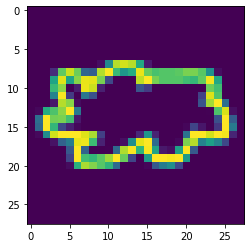

In [11]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_train))
plt.imshow(x_train[idx].reshape(28,28)) 
print(class_names[int(y_train[idx].item())])

# Preprocess the Data 

In [12]:
# Reshape and normalize
x_train = x_train.reshape(x_train.shape[0], image_size, image_size, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], image_size, image_size, 1).astype('float32')

x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# The Model 

In [13]:
# Define model
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(14, activation='softmax')) 
# Train model
adam = tf.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['top_k_categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 576)               0

# Training 

In [14]:
model.fit(x = x_train, y = y_train, validation_split=0.1, batch_size = 256, verbose=2, epochs=5)

Epoch 1/5
158/158 - 8s - loss: 1.1403 - top_k_categorical_accuracy: 0.9174 - val_loss: 0.6789 - val_top_k_categorical_accuracy: 0.9663
Epoch 2/5
158/158 - 1s - loss: 0.6024 - top_k_categorical_accuracy: 0.9693 - val_loss: 0.5524 - val_top_k_categorical_accuracy: 0.9719
Epoch 3/5
158/158 - 1s - loss: 0.4883 - top_k_categorical_accuracy: 0.9754 - val_loss: 0.4620 - val_top_k_categorical_accuracy: 0.9763
Epoch 4/5
158/158 - 1s - loss: 0.4238 - top_k_categorical_accuracy: 0.9792 - val_loss: 0.4300 - val_top_k_categorical_accuracy: 0.9770
Epoch 5/5
158/158 - 1s - loss: 0.3818 - top_k_categorical_accuracy: 0.9812 - val_loss: 0.3925 - val_top_k_categorical_accuracy: 0.9804


# Testing 

In [15]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test accuarcy: {:0.2f}%'.format(score[1] * 100))

Test accuarcy: 98.02%


# Inference 

['candle', 'flower', 'leaf', 'umbrella', 'tree']


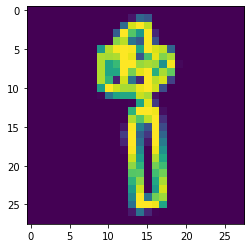

In [16]:
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline  
idx = randint(0, len(x_test))
img = x_test[idx]
plt.imshow(img.squeeze()) 
pred = model.predict(np.expand_dims(img, axis=0))[0]
ind = (-pred).argsort()[:5]
latex = [class_names[x] for x in ind]
print(latex)

# Store the classes 

In [17]:
with open('class_names.txt', 'w') as file_handler:
    for item in class_names:
        file_handler.write("{}\n".format(item))

# Install TensorFlowJS

In [18]:
!pip install tensorflowjs 

     |████████████████████████████████| 71kB 8.1MB/s 
     |████████████████████████████████| 112kB 15.7MB/s 
  Found existing installation: tensorflow-hub 0.11.0
    Uninstalling tensorflow-hub-0.11.0:
      Successfully uninstalled tensorflow-hub-0.11.0


# Save and Convert 

In [19]:
model.save('keras.h5')

In [20]:
!mkdir model
!tensorflowjs_converter --input_format keras keras.h5 model/

2021-02-28 05:24:23.261094: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


# Zip and Download 

In [21]:
!cp class_names.txt model/class_names.txt

In [22]:
!zip -r model.zip model 

  adding: model/ (stored 0%)
  adding: model/class_names.txt (deflated 20%)
  adding: model/group1-shard1of1.bin (deflated 8%)
  adding: model/model.json (deflated 82%)


In [23]:
from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>